In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
file_path = "/content/drive/MyDrive/RM/RM_dataset.xlsx"
df = pd.read_excel(file_path)
df.head()

,Node Id,Timestamp,Timestamp as DateTime,Temperature,Conductivity,pH,DissolvedOxygen
0,1,201505011710380000,2015/05/01 17:10:38 0000,15.12,345.3,7.61,48.2
1,2,201505011720480000,2015/05/01 17:20:48 0000,15.22,345.7,7.36,114.7
2,3,201505011730590016,2015/05/01 17:30:59 0000,15.80,343.9,7.56,114.3
3,4,201505011741100000,2015/05/01 17:41:10 0000,16.25,339.7,7.00,118.5
4,5,201505011751200000,2015/05/01 17:51:20 0000,-0.33,342.7,7.35,113.0


In [ ]:
import pandas as pd
import numpy as np
import random

file_path = "/content/drive/MyDrive/RM/RM_dataset.xlsx"
df = pd.read_excel(file_path)

df.columns = df.columns.str.strip().str.lower()

df["salinity"] = 0.008 * df["conductivity"] + 0.0005 * df["temperature"] - 0.2
np.random.seed(42)
df["distance"] = np.random.uniform(5, 100, size=len(df))

df["energy_consumption"] = 0.1 * df["distance"] + 0.02 * df["salinity"] + 0.05 * df["temperature"]

num_bees = 50
num_iterations = 100
limit = 10

food_sources = df["energy_consumption"].values.copy()
best_solution = min(food_sources)

min_energy = np.min(food_sources[food_sources > 0])
max_energy = np.max(food_sources)

for iteration in range(num_iterations):
    for i in range(num_bees // 2):
        k = random.randint(0, len(food_sources) - 1)
        phi = random.uniform(-1, 1)
        new_solution = food_sources[i] + phi * (food_sources[i] - food_sources[k])
        food_sources[i] = np.clip(new_solution, min_energy, max_energy)

    fitness_values = 1 / (1 + food_sources)
    total_fitness = sum(fitness_values)
    probabilities = np.nan_to_num(fitness_values / total_fitness, nan=1e-10)
    probabilities = np.maximum(probabilities, 0)
    probabilities /= probabilities.sum()

    for i in range(num_bees // 2, num_bees):
        selected_index = np.random.choice(range(len(food_sources)), p=probabilities)
        k = random.randint(0, len(food_sources) - 1)
        phi = random.uniform(-1, 1)
        new_solution = food_sources[selected_index] + phi * (food_sources[selected_index] - food_sources[k])
        food_sources[selected_index] = np.clip(new_solution, min_energy, max_energy)

    for i in range(len(food_sources)):
        if random.randint(0, limit) == 0:
            food_sources[i] = random.uniform(min_energy, max_energy)

    best_solution = min(best_solution, min(food_sources))

df["optimized_energy"] = food_sources

df.to_excel("/content/optimized_results.xlsx", index=False)

df[["node id", "energy_consumption", "optimized_energy"]].head()


,node id,energy_consumption,optimized_energy
0,1,4.865530,7.236461
1,2,10.344250,1.953840
2,3,8.295124,2.707594
3,4,7.050270,2.560504
4,5,2.016506,6.936425


Overall Minimized Energy Consumption: 1.1163
Average Energy Consumption Before Optimization: 6.0179
Average Energy Consumption After Optimization: 1.9343
Energy Reduction: 4.0836
Percentage Improvement: 67.86%


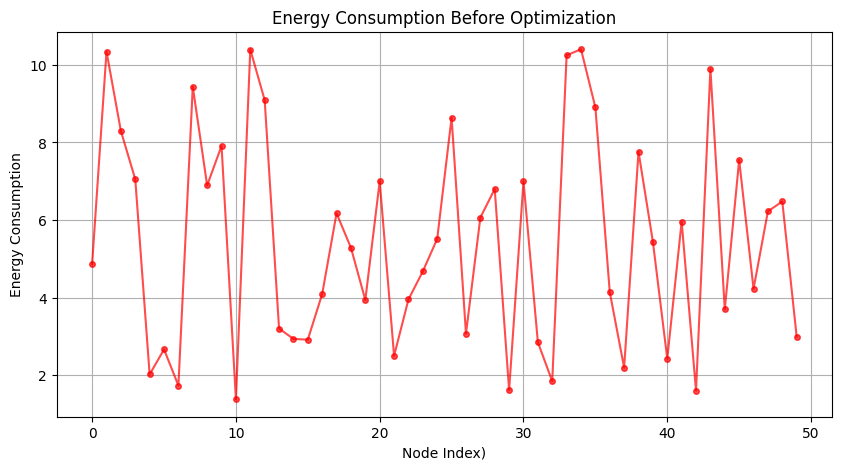

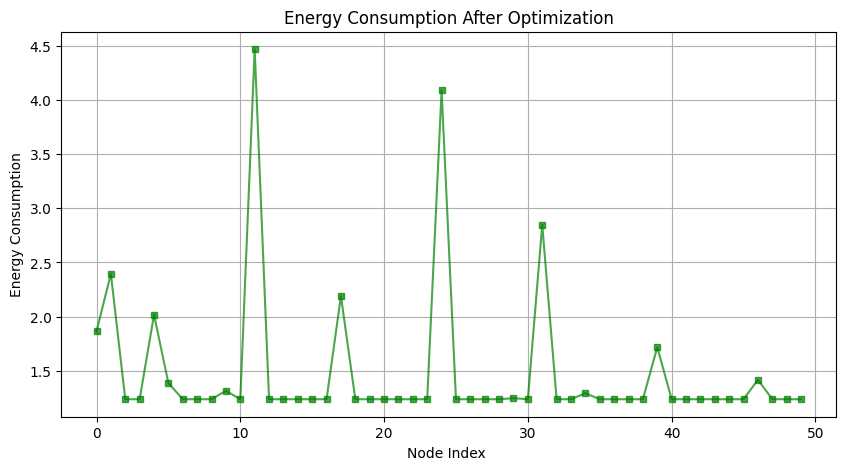

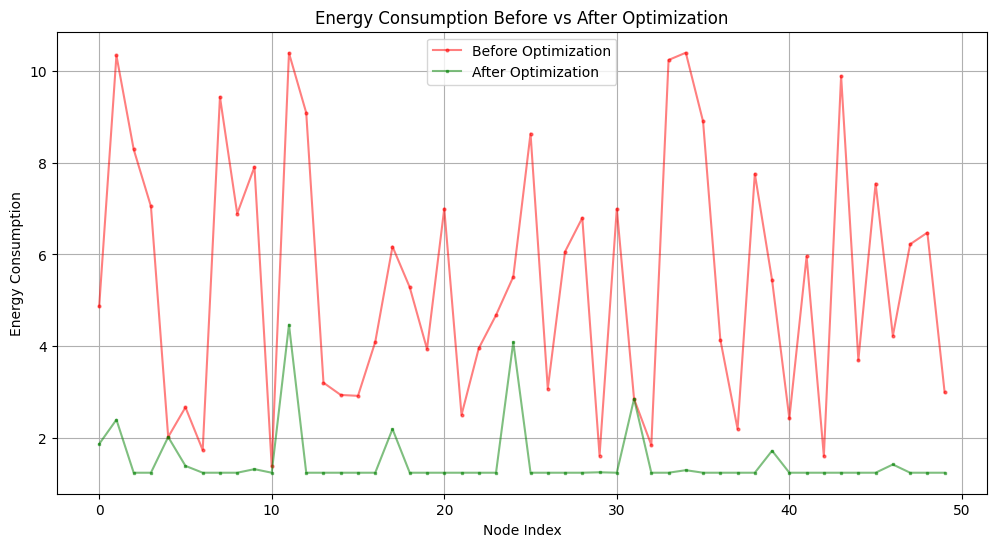

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/RM/RM_dataset.xlsx"
df = pd.read_excel(file_path)

df.columns = df.columns.str.strip().str.lower()

df["salinity"] = 0.008 * df["conductivity"] + 0.0005 * df["temperature"] - 0.2

np.random.seed(42)
df["distance"] = np.random.uniform(5, 100, size=len(df))

df["energy_consumption"] = 0.1 * df["distance"] + 0.02 * df["salinity"] + 0.05 * df["temperature"]

num_bees = 700
num_iterations = 200
limit = 10

food_sources = df["energy_consumption"].values.copy()
best_solution = np.min(food_sources)

min_energy = np.min(food_sources[food_sources > 0]) if np.any(food_sources > 0) else 1e-5
max_energy = np.max(food_sources)

for iteration in range(num_iterations):
    for i in range(num_bees // 2):
        k = random.randint(0, len(food_sources) - 1)
        phi = random.uniform(-1, 1)
        new_solution = food_sources[i] - abs(phi * (food_sources[i] - food_sources[k]))
        if new_solution < food_sources[i]:
            food_sources[i] = np.clip(new_solution, min_energy, max_energy)

    norm_food_sources = (food_sources - min_energy) / (max_energy - min_energy)
    fitness_values = 1 / (1 + np.exp(-norm_food_sources))

    total_fitness = np.sum(fitness_values)
    probabilities = fitness_values / total_fitness if total_fitness > 0 else np.full_like(fitness_values, 1 / len(fitness_values))

    for i in range(num_bees // 2, num_bees):
        selected_index = np.random.choice(range(len(food_sources)), p=probabilities)
        k = random.randint(0, len(food_sources) - 1)
        phi = random.uniform(-1, 1)
        new_solution = food_sources[selected_index] - abs(phi * (food_sources[selected_index] - food_sources[k]))
        if new_solution < food_sources[selected_index]:
            food_sources[selected_index] = np.clip(new_solution, min_energy, max_energy)
    for i in range(len(food_sources)):
        if random.randint(0, limit) == 0:
            food_sources[i] = random.uniform(min_energy * 0.9, max_energy * 0.9)
    best_solution = min(best_solution, np.min(food_sources))

df["optimized_energy"] = np.minimum(df["energy_consumption"], food_sources)

avg_energy_before = df["energy_consumption"].mean()
avg_energy_after = df["optimized_energy"].mean()
energy_reduction = avg_energy_before - avg_energy_after
percentage_improvement = (energy_reduction / avg_energy_before) * 100

print(f"Overall Minimized Energy Consumption: {best_solution:.4f}")
print(f"Average Energy Consumption Before Optimization: {avg_energy_before:.4f}")
print(f"Average Energy Consumption After Optimization: {avg_energy_after:.4f}")
print(f"Energy Reduction: {energy_reduction:.4f}")
print(f"Percentage Improvement: {percentage_improvement:.2f}%")

df.to_excel("/content/optimized_results.xlsx", index=False)

df_subset = df.iloc[:50]
plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["energy_consumption"], color="red", linestyle='-', marker='o', markersize=4, alpha=0.7)
plt.xlabel("Node Index)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["optimized_energy"], color="green", linestyle='-', marker='s', markersize=4, alpha=0.7)
plt.xlabel("Node Index ")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption After Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, df_subset["energy_consumption"], label="Before Optimization", color="red", linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.plot(df_subset.index, df_subset["optimized_energy"], label="After Optimization", color="green", linestyle='-', marker='s', markersize=2, alpha=0.5)
plt.xlabel("Node Index")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before vs After Optimization")
plt.legend()
plt.grid(True)
plt.show()

Overall Minimized Energy Consumption: 0.8656
Average Energy Consumption Before Optimization: 6.0179
Average Energy Consumption After Optimization: 4.2125
Energy Reduction: 1.8054
Percentage Improvement: 30.00%


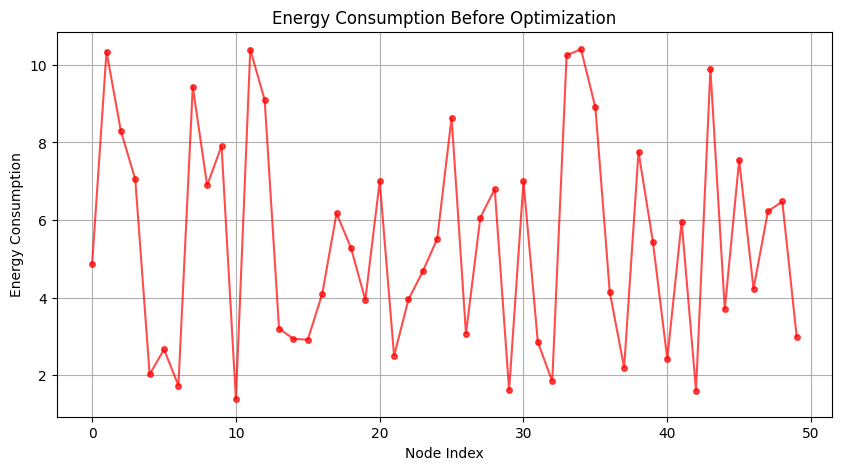

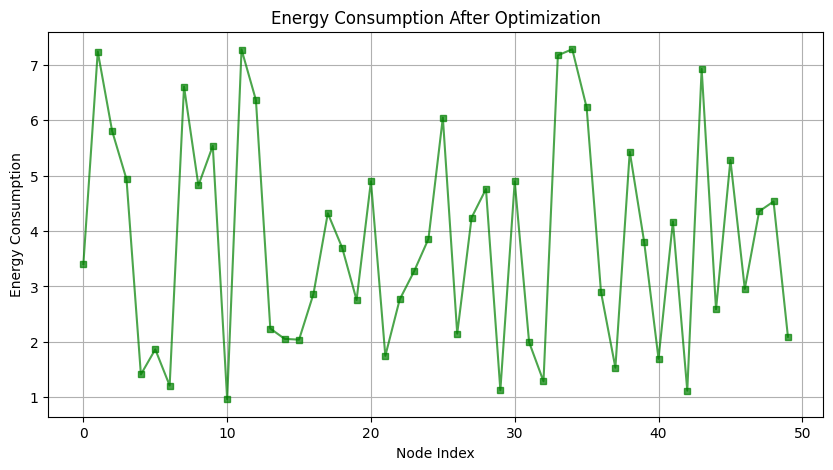

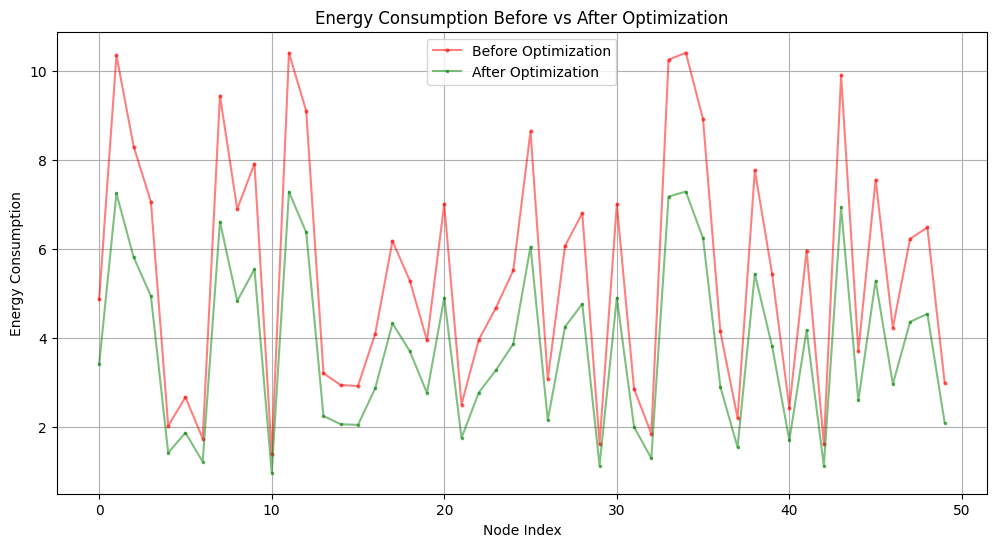

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

file_path = "/content/drive/MyDrive/RM/RM_dataset.xlsx"
df = pd.read_excel(file_path)

df.columns = df.columns.str.strip().str.lower()

df["salinity"] = 0.008 * df["conductivity"] + 0.0005 * df["temperature"] - 0.2

np.random.seed(42)
df["distance"] = np.random.uniform(5, 100, size=len(df))

df["energy_consumption"] = 0.1 * df["distance"] + 0.02 * df["salinity"] + 0.05 * df["temperature"]

def energy_function(energy_values):
    return np.sum(energy_values)

energy_bounds = [(0.7 * val, 1.3 * val) for val in df["energy_consumption"]]

result = differential_evolution(
    energy_function,
    bounds=energy_bounds,
    strategy='best1bin',
    mutation=(0.4, 0.9),
    recombination=0.8,
    maxiter=2000,
    popsize=100
)

df["optimized_energy"] = result.x

overall_min_energy = df["optimized_energy"].min()
print(f"Overall Minimized Energy Consumption: {overall_min_energy:.4f}")

avg_energy_before = df["energy_consumption"].mean()
avg_energy_after = df["optimized_energy"].mean()
energy_reduction = avg_energy_before - avg_energy_after
percentage_improvement = (energy_reduction / avg_energy_before) * 100

print(f"Average Energy Consumption Before Optimization: {avg_energy_before:.4f}")
print(f"Average Energy Consumption After Optimization: {avg_energy_after:.4f}")
print(f"Energy Reduction: {energy_reduction:.4f}")
print(f"Percentage Improvement: {percentage_improvement:.2f}%")

df.to_excel("/content/optimized_results_de.xlsx", index=False)

df_subset = df.iloc[:50]

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["energy_consumption"], color="red", linestyle='-', marker='o', markersize=4, alpha=0.7)
plt.xlabel("Node Index")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["optimized_energy"], color="green", linestyle='-', marker='s', markersize=4, alpha=0.7)
plt.xlabel("Node Index")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption After Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, df_subset["energy_consumption"], label="Before Optimization", color="red", linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.plot(df_subset.index, df_subset["optimized_energy"], label="After Optimization", color="green", linestyle='-', marker='s', markersize=2, alpha=0.5)
plt.xlabel("Node Index")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before vs After Optimization")
plt.legend()
plt.grid(True)
plt.show()


Overall Minimized Energy Consumption: 1.2564
Average Energy Consumption Before Optimization: 6.0179
Average Energy Consumption After Optimization: 2.2312
Energy Reduction: 3.7867
Percentage Improvement: 62.92%


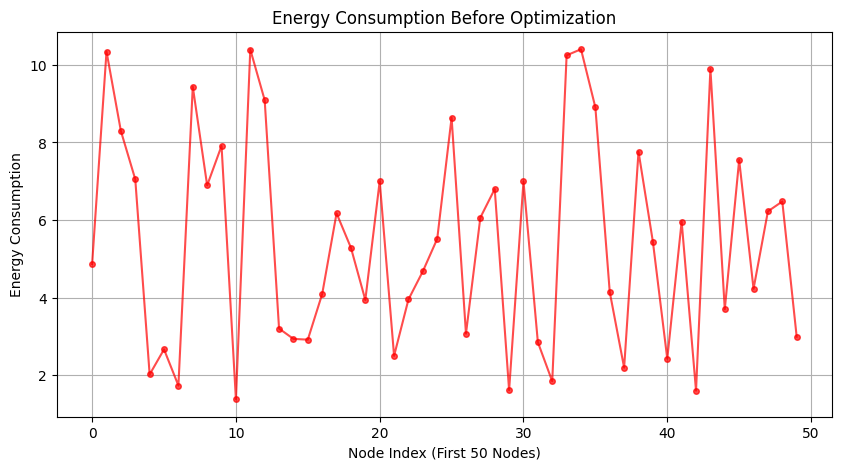

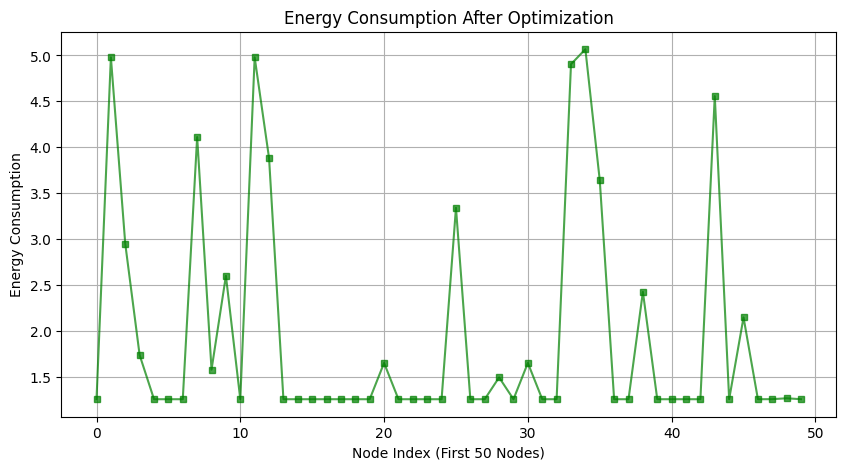

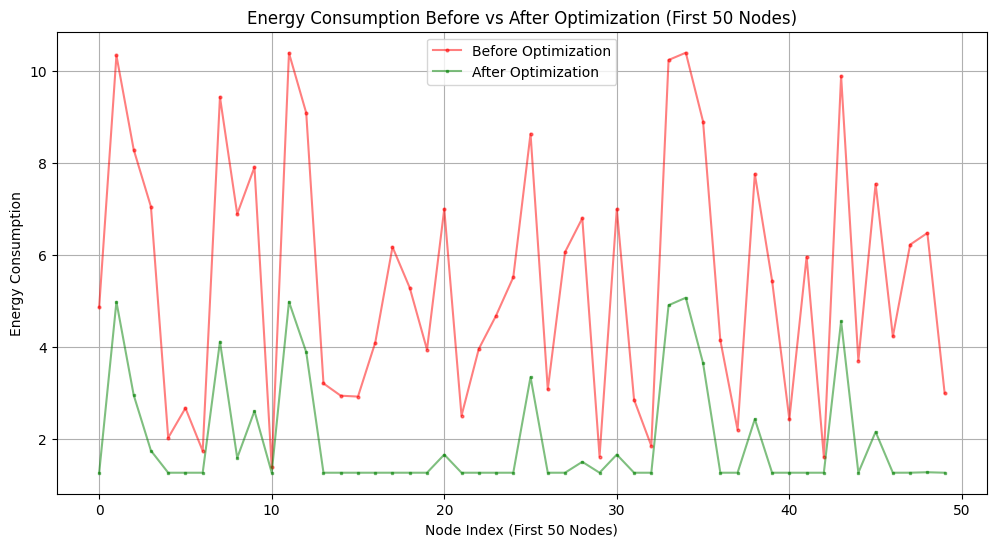

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/RM/RM_dataset.xlsx"
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip().str.lower()

df["salinity"] = 0.008 * df["conductivity"] + 0.0005 * df["temperature"] - 0.2

np.random.seed(42)
df["distance"] = np.random.uniform(5, 100, size=len(df))

df["energy_consumption"] = 0.1 * df["distance"] + 0.02 * df["salinity"] + 0.05 * df["temperature"]

num_glowworms = 700
num_iterations = 150
luciferin_decay = 0.4
luciferin_enhancement = 0.7
step_size = 0.15
neighbor_radius = 1.0

glowworms = df["energy_consumption"].values.copy()
luciferin = np.ones(len(glowworms))

for iteration in range(num_iterations):
    luciferin = (1 - luciferin_decay) * luciferin + luciferin_enhancement / (1 + glowworms)

    for i in range(num_glowworms):
        neighbors = [j for j in range(num_glowworms) if i != j and abs(glowworms[i] - glowworms[j]) < neighbor_radius]

        if neighbors:
            best_neighbor = max(neighbors, key=lambda j: luciferin[j])
            glowworms[i] += step_size * (glowworms[best_neighbor] - glowworms[i])

    neighbor_radius = max(0.1, neighbor_radius * 0.97)

df["optimized_energy"] = glowworms

overall_min_energy = df["optimized_energy"].min()
print(f"Overall Minimized Energy Consumption: {overall_min_energy:.4f}")

avg_energy_before = df["energy_consumption"].mean()
avg_energy_after = df["optimized_energy"].mean()
energy_reduction = avg_energy_before - avg_energy_after
percentage_improvement = (energy_reduction / avg_energy_before) * 100

print(f"Average Energy Consumption Before Optimization: {avg_energy_before:.4f}")
print(f"Average Energy Consumption After Optimization: {avg_energy_after:.4f}")
print(f"Energy Reduction: {energy_reduction:.4f}")
print(f"Percentage Improvement: {percentage_improvement:.2f}%")

df.to_excel("/content/optimized_results_gso.xlsx", index=False)

df_subset = df.iloc[:50]

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["energy_consumption"], color="red", linestyle='-', marker='o', markersize=4, alpha=0.7)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["optimized_energy"], color="green", linestyle='-', marker='s', markersize=4, alpha=0.7)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption After Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, df_subset["energy_consumption"], label="Before Optimization", color="red", linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.plot(df_subset.index, df_subset["optimized_energy"], label="After Optimization", color="green", linestyle='-', marker='s', markersize=2, alpha=0.5)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before vs After Optimization (First 50 Nodes)")
plt.legend()
plt.grid(True)
plt.show()

Overall Minimized Energy Consumption: 1.0771
Average Energy Consumption Before Optimization: 6.0179
Average Energy Consumption After Optimization: 5.8231
Energy Reduction: 0.1948
Percentage Improvement: 3.24%


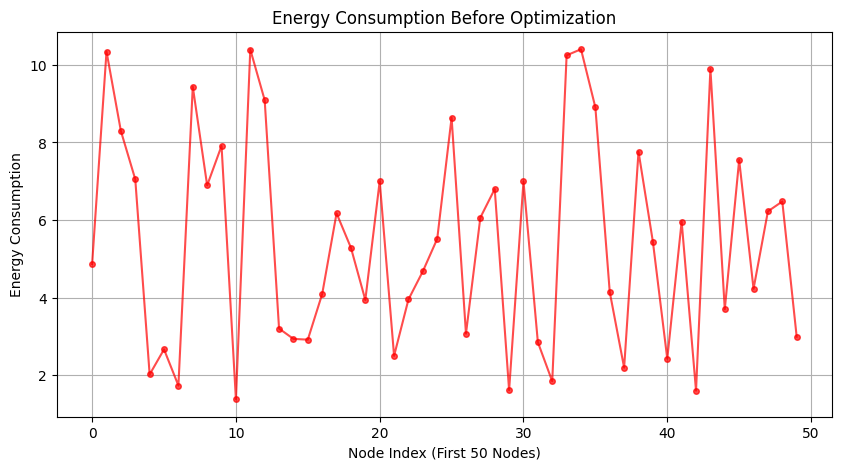

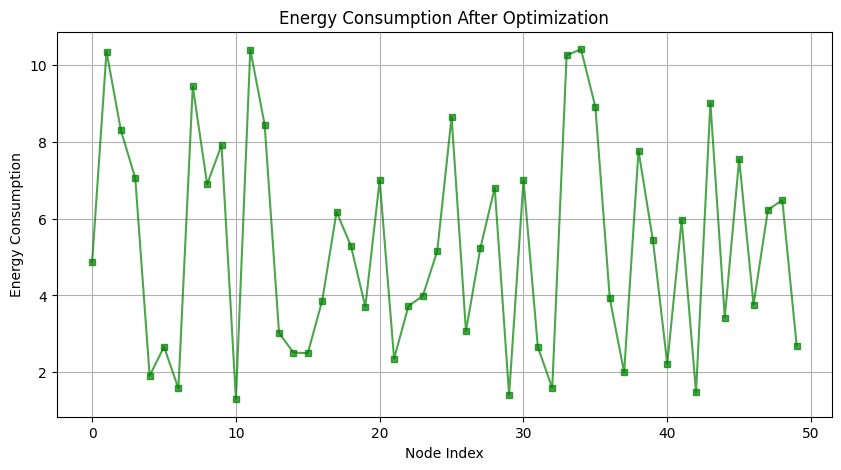

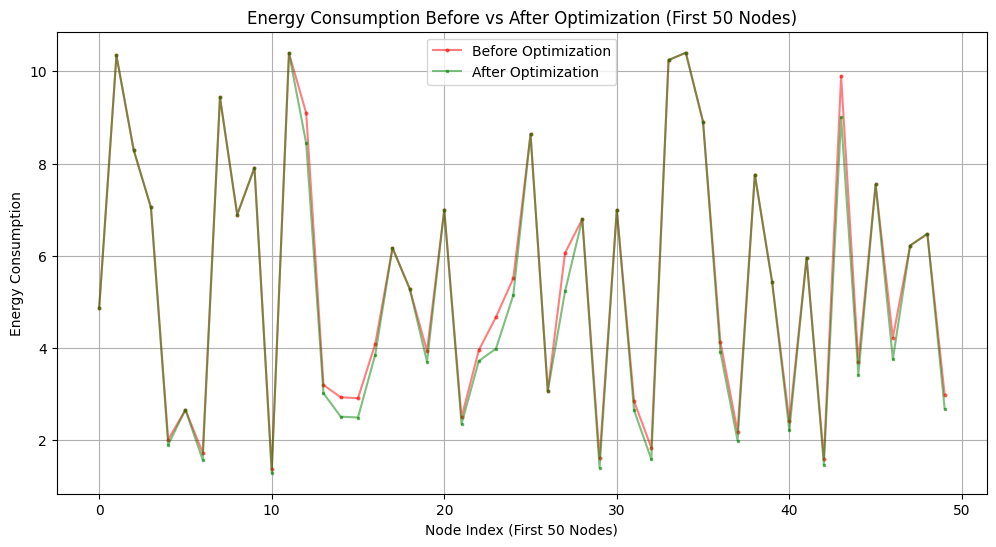

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/RM/RM_dataset.xlsx"
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip().str.lower()

df["salinity"] = 0.008 * df["conductivity"] + 0.0005 * df["temperature"] - 0.2

np.random.seed(42)
df["distance"] = np.random.uniform(5, 100, size=len(df))

df["energy_consumption"] = 0.1 * df["distance"] + 0.02 * df["salinity"] + 0.05 * df["temperature"]

df["optimized_energy"] = df["energy_consumption"].copy()

num_ants = 700
num_iterations = 100
alpha = 1.0
beta = 2.0
evaporation = 0.5
q = 100
exploration_factor = 0.2

pheromones = np.ones(len(df))
heuristic = 1 / (df["energy_consumption"].values + 1e-10)

for iteration in range(num_iterations):
    new_solutions = []

    for ant in range(num_ants):
        probabilities = (pheromones ** alpha) * (heuristic ** beta)
        probabilities /= probabilities.sum()

        selected_index = np.random.choice(range(len(df)), p=probabilities)

        delta = np.random.uniform(0.05, 0.15) * df.loc[selected_index, "energy_consumption"]
        new_energy = df.loc[selected_index, "energy_consumption"] - delta
        new_energy = max(0, new_energy)

        new_solutions.append((selected_index, new_energy))

    pheromones *= (1 - evaporation)
    for idx, new_energy in new_solutions:
        pheromones[idx] += (q / (new_energy + 1e-10))

    for idx, new_energy in new_solutions:
        df.loc[idx, "optimized_energy"] = new_energy

overall_min_energy = df["optimized_energy"].min()
print(f"Overall Minimized Energy Consumption: {overall_min_energy:.4f}")

avg_energy_before = df["energy_consumption"].mean()
avg_energy_after = df["optimized_energy"].mean()
energy_reduction = avg_energy_before - avg_energy_after
percentage_improvement = (energy_reduction / avg_energy_before) * 100

print(f"Average Energy Consumption Before Optimization: {avg_energy_before:.4f}")
print(f"Average Energy Consumption After Optimization: {avg_energy_after:.4f}")
print(f"Energy Reduction: {energy_reduction:.4f}")
print(f"Percentage Improvement: {percentage_improvement:.2f}%")

df.to_excel("/content/optimized_results_aco_fixed.xlsx", index=False)

df_subset = df.iloc[:50]

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["energy_consumption"], color="red", linestyle='-', marker='o', markersize=4, alpha=0.7)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["optimized_energy"], color="green", linestyle='-', marker='s', markersize=4, alpha=0.7)
plt.xlabel("Node Index")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption After Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, df_subset["energy_consumption"], label="Before Optimization", color="red", linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.plot(df_subset.index, df_subset["optimized_energy"], label="After Optimization", color="green", linestyle='-', marker='s', markersize=2, alpha=0.5)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before vs After Optimization (First 50 Nodes)")
plt.legend()
plt.grid(True)
plt.show()


Overall Minimized Energy Consumption: 1.2366
Average Energy Consumption Before Optimization: 6.0179
Average Energy Consumption After Optimization: 5.0734
Energy Reduction: 0.9445
Percentage Improvement: 15.69%


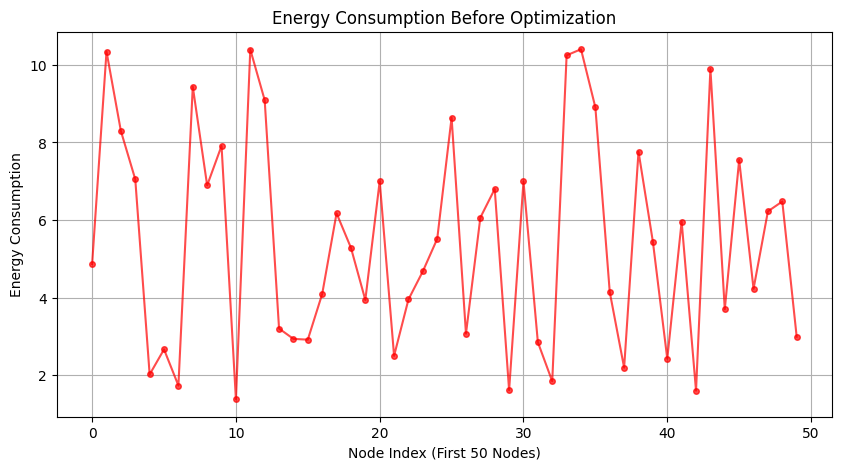

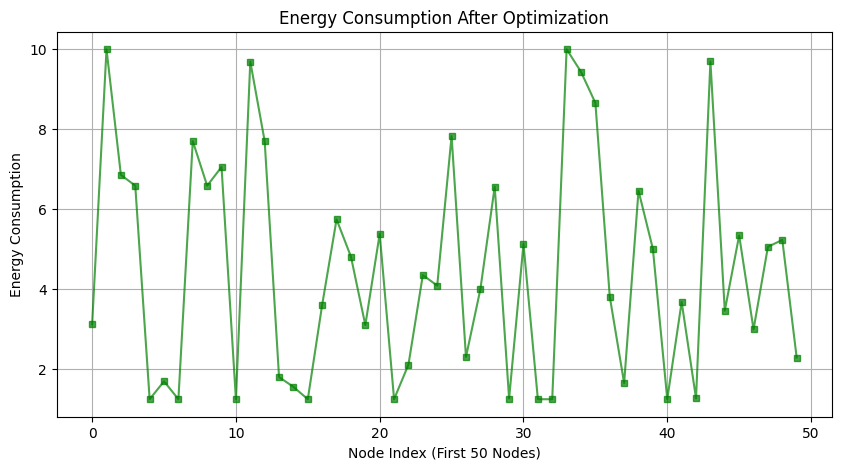

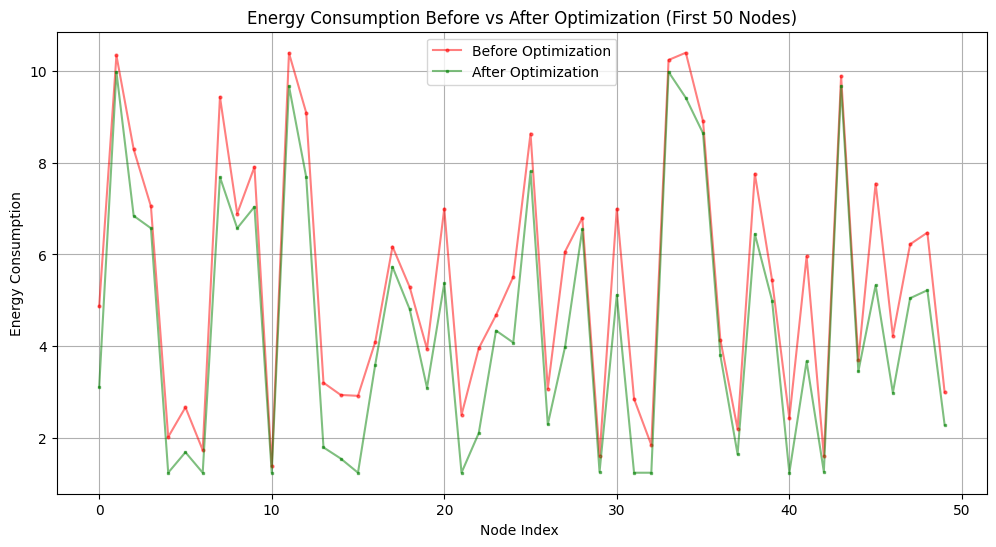

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/RM/RM_dataset.xlsx"
df = pd.read_excel(file_path)

df.columns = df.columns.str.strip().str.lower()

df["salinity"] = 0.008 * df["conductivity"] + 0.0005 * df["temperature"] - 0.2

np.random.seed(42)
df["distance"] = np.random.uniform(5, 100, size=len(df))

df["energy_consumption"] = 0.1 * df["distance"] + 0.02 * df["salinity"] + 0.05 * df["temperature"]

num_particles = 700
num_iterations = 100
w = 0.7
c1 = 1.5
c2 = 1.5

particles = np.array([df["energy_consumption"].values + np.random.uniform(-0.1, 0.1, len(df)) for _ in range(num_particles)])
velocities = np.random.uniform(-0.05, 0.05, size=particles.shape)

personal_best_positions = particles.copy()
personal_best_scores = np.array([np.min(p) for p in particles])
global_best_position = personal_best_positions[np.argmin(personal_best_scores)]

for iteration in range(num_iterations):
    for i in range(num_particles):
        current_score = np.min(particles[i])
        if current_score < personal_best_scores[i]:
            personal_best_scores[i] = current_score
            personal_best_positions[i] = particles[i]

    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]

    for i in range(num_particles):
        r1, r2 = np.random.rand(), np.random.rand()
        velocities[i] = (w * velocities[i] +
                         c1 * r1 * (personal_best_positions[i] - particles[i]) +
                         c2 * r2 * (global_best_position - particles[i]))

        particles[i] += velocities[i]

    particles = np.clip(particles, df["energy_consumption"].min(), df["energy_consumption"].max())

df["optimized_energy"] = np.min(particles, axis=0)

overall_min_energy = df["optimized_energy"].min()
print(f"Overall Minimized Energy Consumption: {overall_min_energy:.4f}")

avg_energy_before = df["energy_consumption"].mean()
avg_energy_after = df["optimized_energy"].mean()
energy_reduction = avg_energy_before - avg_energy_after
percentage_improvement = (energy_reduction / avg_energy_before) * 100

print(f"Average Energy Consumption Before Optimization: {avg_energy_before:.4f}")
print(f"Average Energy Consumption After Optimization: {avg_energy_after:.4f}")
print(f"Energy Reduction: {energy_reduction:.4f}")
print(f"Percentage Improvement: {percentage_improvement:.2f}%")

df.to_excel("/content/optimized_results_pso.xlsx", index=False)

df_subset = df.iloc[:50]

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["energy_consumption"], color="red", linestyle='-', marker='o', markersize=4, alpha=0.7)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["optimized_energy"], color="green", linestyle='-', marker='s', markersize=4, alpha=0.7)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption After Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, df_subset["energy_consumption"], label="Before Optimization", color="red", linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.plot(df_subset.index, df_subset["optimized_energy"], label="After Optimization", color="green", linestyle='-', marker='s', markersize=2, alpha=0.5)
plt.xlabel("Node Index ")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before vs After Optimization (First 50 Nodes)")
plt.legend()
plt.grid(True)
plt.show()


Overall Minimized Energy Consumption: 1.0248
Average Energy Consumption Before Optimization: 6.0179
Average Energy Consumption After Optimization: 5.7703
Energy Reduction: 0.2476
Percentage Improvement: 4.11%


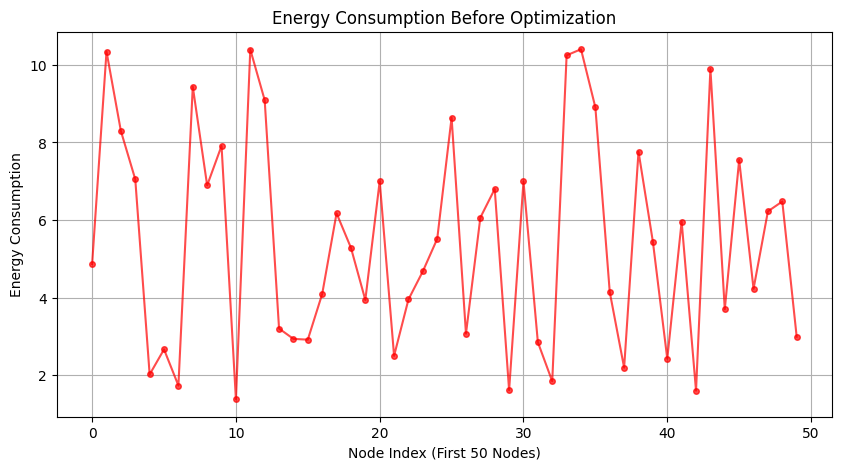

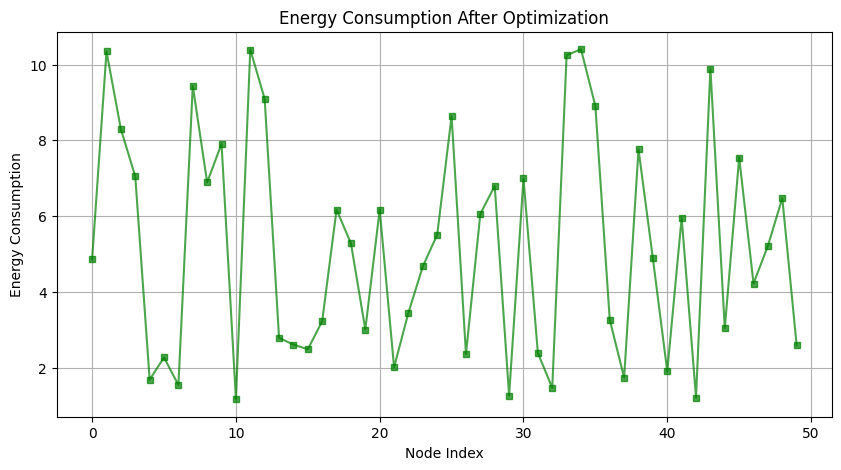

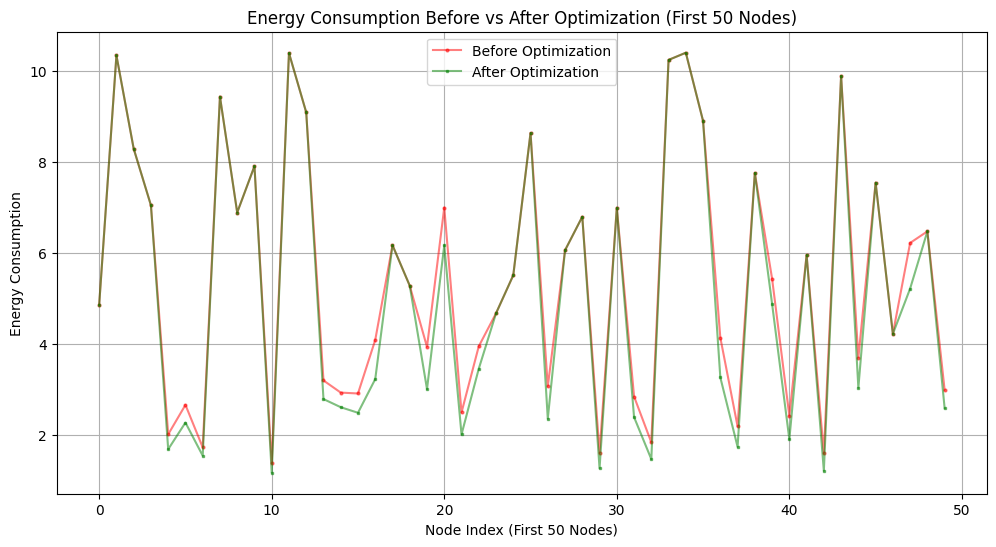

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/RM/RM_dataset.xlsx"
df = pd.read_excel(file_path)

df.columns = df.columns.str.strip().str.lower()

df["salinity"] = 0.008 * df["conductivity"] + 0.0005 * df["temperature"] - 0.2

np.random.seed(42)
df["distance"] = np.random.uniform(5, 100, size=len(df))

df["energy_consumption"] = 0.1 * df["distance"] + 0.02 * df["salinity"] + 0.05 * df["temperature"]

df["optimized_energy"] = df["energy_consumption"].copy()

num_ants = 700
num_iterations = 200
alpha = 1.2
beta = 2.5
evaporation = 0.4
q = 200
exploration_factor = 0.3

pheromones = np.ones(len(df))
heuristic = 1 / (df["energy_consumption"].values + 1e-10)

for iteration in range(num_iterations):
    new_solutions = []

    for ant in range(num_ants):
        probabilities = (pheromones ** alpha) * (heuristic ** beta)
        probabilities /= probabilities.sum()

        selected_index = np.random.choice(range(len(df)), p=probabilities)

        delta = np.random.uniform(0.10, 0.25) * df.loc[selected_index, "energy_consumption"]
        new_energy = df.loc[selected_index, "energy_consumption"] - delta
        new_energy = max(0, new_energy)

        new_solutions.append((selected_index, new_energy))

    pheromones *= (1 - evaporation)

    for idx, new_energy in new_solutions:
        pheromones[idx] += (q / (new_energy + 1e-10))

    for idx, new_energy in new_solutions:
        df.loc[idx, "optimized_energy"] = new_energy

overall_min_energy = df["optimized_energy"].min()
print(f"Overall Minimized Energy Consumption: {overall_min_energy:.4f}")

avg_energy_before = df["energy_consumption"].mean()
avg_energy_after = df["optimized_energy"].mean()
energy_reduction = avg_energy_before - avg_energy_after
percentage_improvement = (energy_reduction / avg_energy_before) * 100

print(f"Average Energy Consumption Before Optimization: {avg_energy_before:.4f}")
print(f"Average Energy Consumption After Optimization: {avg_energy_after:.4f}")
print(f"Energy Reduction: {energy_reduction:.4f}")
print(f"Percentage Improvement: {percentage_improvement:.2f}%")

df.to_excel("/content/optimized_results_aco_improved.xlsx", index=False)

df_subset = df.iloc[:50]

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["energy_consumption"], color="red", linestyle='-', marker='o', markersize=4, alpha=0.7)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_subset.index, df_subset["optimized_energy"], color="green", linestyle='-', marker='s', markersize=4, alpha=0.7)
plt.xlabel("Node Index")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption After Optimization")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, df_subset["energy_consumption"], label="Before Optimization", color="red", linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.plot(df_subset.index, df_subset["optimized_energy"], label="After Optimization", color="green", linestyle='-', marker='s', markersize=2, alpha=0.5)
plt.xlabel("Node Index (First 50 Nodes)")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Before vs After Optimization (First 50 Nodes)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

num_food_sources = 10  
num_dimensions = 5      
max_cycles = 100        
limit = 10              

min_energy, max_energy = -10, 10

food_sources = np.random.uniform(low=min_energy, high=max_energy, size=(num_food_sources, num_dimensions))

def fitness(solution):
    return 1 / (1 + np.sum(solution**2))  

fitness_values = np.array([fitness(fs) for fs in food_sources])
counters = np.zeros(num_food_sources)  
cycle = 0


while cycle < max_cycles:
    for i in range(num_food_sources):
        
        partner = np.random.randint(0, num_food_sources)  
        dim = np.random.randint(0, num_dimensions)  

        new_solution = np.copy(food_sources[i])
        new_solution[dim] += np.random.uniform(-1, 1) * (food_sources[i][dim] - food_sources[partner][dim])

        new_fitness = fitness(new_solution)

        if new_fitness > fitness_values[i]: 
            food_sources[i] = new_solution
            fitness_values[i] = new_fitness
            counters[i] = 0  
        else:
            counters[i] += 1  

    probabilities = fitness_values / np.sum(fitness_values)  
    cumulative_probabilities = np.cumsum(probabilities)

    for _ in range(num_food_sources):
        r = np.random.rand()
        selected_index = np.where(cumulative_probabilities > r)[0][0]

        partner = np.random.randint(0, num_food_sources)
        dim = np.random.randint(0, num_dimensions)

        new_solution = np.copy(food_sources[selected_index])
        new_solution[dim] += np.random.uniform(-1, 1) * (food_sources[selected_index][dim] - food_sources[partner][dim])

        new_fitness = fitness(new_solution)

        if new_fitness > fitness_values[selected_index]:
            food_sources[selected_index] = new_solution
            fitness_values[selected_index] = new_fitness
            counters[selected_index] = 0
        else:
            counters[selected_index] += 1
    for i in range(num_food_sources):
        if counters[i] > limit:
            food_sources[i] = np.random.uniform(min_energy, max_energy, size=num_dimensions)
            fitness_values[i] = fitness(food_sources[i])
            counters[i] = 0  

    cycle += 1

best_index = np.argmax(fitness_values)
best_solution = food_sources[best_index]

print("Best Solution Found:", best_solution)
print("Best Fitness Value:", fitness_values[best_index])


Best Solution Found: [-0.10011403 -0.26483352  0.00824255  0.01291979 -0.16301996]
Best Fitness Value: 0.9033668645260656
